# Milestone Project 1 : Food Vision Big(TM)

In [1]:
# Install TensorFlow 2.9.0 to avoid issues (later versions may work)
# -U stands for "update" and "-q" stands for "quiet"
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]='2'
import tensorflow as tf
if tf.__version__ != "2.9.0":
  !pip install -U -q tensorflow==2.9.0
  !pip install -q tensorflow_datasets==4.8.2
  !pip install -q protobuf==3.19.6
  !pip install -q tensorflow_metadata==1.12.0
  # import os
  # os._exit(00)
print(tf.__version__)

2.9.0


In [2]:
gpu=tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(gpu[0],True)

In [3]:
import os

if not os.path.exists("helper_functions.py"):
  !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
  print("[INFO] 'helper_functions.py' already exists, skipping download.")

# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

[INFO] 'helper_functions.py' already exists, skipping download.


In [4]:
! nvidia-smi

zsh:1: command not found: nvidia-smi


In [5]:
! nvidia-smi -L

zsh:1: command not found: nvidia-smi


# Use Tensorflow Datasets

In [6]:
import tensorflow_datasets as tdfs
dataset_list = tdfs.list_builders()
print("food101" in dataset_list)

True


In [7]:
# Load the data
(train_data,test_data), ds_info = tdfs.load(name="food101",
                                            split=["train","validation"],
                                            shuffle_files=True,
                                            as_supervised=True,
                                            with_info=True)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [8]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
# Features in Food101 from tfds
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [10]:
# take one sample of train_data
train_one_sample = train_data.take(1)

# Exploring the Food101 data from TensorFlow Datasets
Now we've downloaded the Food101 dataset from TensorFlow Datasets, how about we do what any good data explorer should?

In other words, "visualize, visualize, visualize".

Let's find out a few details about our dataset:

* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels of our input data look like (e.g. one-hot encoded versus label-encoded)
* Do the labels match up with the class names?

To do, let's take one sample off the training data (using the .take() method) and explore it.

In [11]:
# What does one sample of training data look like
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [12]:
# Output info about training sample
for image,label in train_one_sample:
  print(f"""
  Image shape: {image.shape},
  Image datatype: {image.dtype},
  Target class(tensor form): {label},
  Class name(str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3),
  Image datatype: <dtype: 'uint8'>,
  Target class(tensor form): 18,
  Class name(str form): chicken_curry
  


In [13]:
#How does image look like:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[170, 193, 165],
        [175, 198, 170],
        [187, 209, 186],
        ...,
        [253, 255, 249],
        [253, 255, 249],
        [253, 255, 249]],

       [[169, 185, 159],
        [169, 184, 161],
        [171, 189, 167],
        ...,
        [253, 255, 249],
        [253, 255, 249],
        [253, 255, 249]],

       [[166, 171, 151],
        [161, 166, 146],
        [158, 165, 147],
        ...,
        [253, 255, 249],
        [253, 255, 249],
        [253, 255, 249]],

       ...,

       [[143, 131, 105],
        [143, 131, 105],
        [141, 132, 103],
        ...,
        [152, 131, 104],
        [153, 129, 103],
        [151, 127, 101]],

       [[139, 129, 102],
        [138, 128, 101],
        [137, 128,  99],
        ...,
        [150, 126, 100],
        [151, 125, 100],
        [152, 126,  99]],

       [[133, 123,  96],
        [134, 124,  97],
        [136, 127,  98],
        ...,
        [149, 125,  9

In [14]:
tf.reduce_min(image),tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=5>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

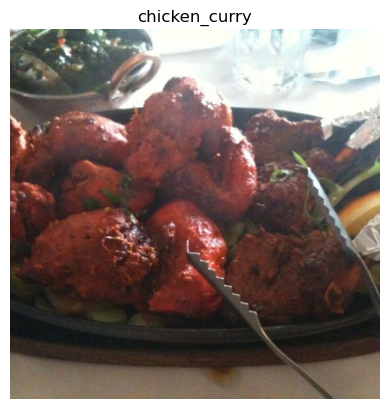

In [15]:
### Plot an image from tensorflow datasets
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

## Create preprocessing functions for our data

What we know about the data:
* It is in `uint8` datatype
* Image is not scaled
* Different sized images/tensors

What we know model prefers:
* Data in `float32` dtype
* For batches, tf likes all of tensors within a batch to be of same size
* Scaled (values between 0 and 1)



In [16]:
image,label

(<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
 array([[[170, 193, 165],
         [175, 198, 170],
         [187, 209, 186],
         ...,
         [253, 255, 249],
         [253, 255, 249],
         [253, 255, 249]],
 
        [[169, 185, 159],
         [169, 184, 161],
         [171, 189, 167],
         ...,
         [253, 255, 249],
         [253, 255, 249],
         [253, 255, 249]],
 
        [[166, 171, 151],
         [161, 166, 146],
         [158, 165, 147],
         ...,
         [253, 255, 249],
         [253, 255, 249],
         [253, 255, 249]],
 
        ...,
 
        [[143, 131, 105],
         [143, 131, 105],
         [141, 132, 103],
         ...,
         [152, 131, 104],
         [153, 129, 103],
         [151, 127, 101]],
 
        [[139, 129, 102],
         [138, 128, 101],
         [137, 128,  99],
         ...,
         [150, 126, 100],
         [151, 125, 100],
         [152, 126,  99]],
 
        [[133, 123,  96],
         [134, 124,  97],
         [136,

In [17]:
# Use efficient net , no need to rescale, only need to reshape and cast the dtype
def preprocess_img(image,label,image_shape=224):
  image = tf.image.resize(image,[image_shape,image_shape])
  # image=image/255.
  return tf.cast(image,dtype=tf.float32), label

In [18]:
# Preprocess single sample
preprocessed_img1 = preprocess_img(image,label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape}...,\nDtype: {image.dtype}\n\n")
print(f"Image after preprocessing:\n {preprocessed_img1[:2]}...,\nShape: {preprocessed_img1.shape}...,\nDtype: {preprocessed_img1.dtype}")

Image before preprocessing:
 [[[170 193 165]
  [175 198 170]
  [187 209 186]
  ...
  [253 255 249]
  [253 255 249]
  [253 255 249]]

 [[169 185 159]
  [169 184 161]
  [171 189 167]
  ...
  [253 255 249]
  [253 255 249]
  [253 255 249]]]...,
Shape: (512, 512, 3)...,
Dtype: <dtype: 'uint8'>


Image after preprocessing:
 [[[170.5051  188.59184 163.11736]
  [187.9898  206.82143 186.91837]
  [208.97958 225.69388 212.7653 ]
  ...
  [253.      255.      249.     ]
  [253.      255.      249.     ]
  [253.      255.      249.     ]]

 [[155.02551 149.47958 134.38776]
  [149.11224 149.47958 137.11734]
  [153.97449 162.87245 152.42857]
  ...
  [253.      255.      249.     ]
  [253.      255.      249.     ]
  [253.      255.      249.     ]]]...,
Shape: (224, 224, 3)...,
Dtype: <dtype: 'float32'>


Batch input data

In [19]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=16).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(16).prefetch(tf.data.AUTOTUNE)

In [20]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

### Creating model callbacks

1. Create Tensorboard callback
2. ModelCheckpoint callback

In [21]:
from helper_functions import create_tensorboard_callback

checkpoint_path = 'model_checkpoint/cp.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='val_accuracy',
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

### Set up mixed precission training

In [22]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  METAL, no compute capability (probably not an Nvidia GPU)
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  METAL, no compute capability (probably not an Nvidia GPU)
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [23]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [24]:
# Build feature extraction model
mixed_precision.set_global_policy("float32")  # Set it to mixed_float16 in tf.__version__==2.4.1
input_shape=(224,224,3)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs = tf.keras.layers.Input(shape=input_shape)
x = base_model(inputs,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(len(class_names))(x)

outputs = tf.keras.layers.Activation(tf.keras.activations.softmax,dtype=tf.float32)(x)

model=tf.keras.Model(inputs,outputs)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 activation (Activation)     (None, 101)               0         
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_____________________________________________

# Fit the model

In [25]:
history_101_feature_extract = model.fit(train_data,
                                        epochs=5,
                                        steps_per_epoch=len(train_data),
                                        validation_data=test_data,
                                        validation_steps=int(0.15*len(test_data)),
                                        callbacks=[model_checkpoint])

Epoch 1/5


  89/4735 [..............................] - ETA: 8:35 - loss: 4.0574 - accuracy: 0.1376

KeyboardInterrupt: 

In [ ]:
#Evaluate
result = model.evaluate(test_data)

790/790 [==============================] - 14s 18ms/step - loss: 0.9684 - accuracy: 0.7360


In [ ]:
for i,layers in enumerate(model.layers):
  print(i,layers.name)

0 input_2
1 efficientnetb0
2 global_average_pooling2d
3 dense
4 activation


In [ ]:
for i,layer in enumerate(model.layers[1].layers):
  print(i,layer.name,layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
model.layers[1].trainable=True
for layer in model.layers[1].layers[:-15]:
  layer.trainable=False

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 activation (Activation)     (None, 101)               0         
                                                                 
Total params: 4,178,952
Trainable params: 1,037,589
Non-trainable params: 3,141,363
___________________________________________

In [ ]:
history_101_fine_tune = model.fit(train_data,
                                  epochs=10,
                                  initial_epoch=history_101_feature_extract.epoch[-1],
                                  validation_data=test_data,
                                  validation_steps=int(0.15*len(test_data)),
                                  steps_per_epoch=len(train_data))

Epoch 5/10
2368/2368 [==============================] - 67s 25ms/step - loss: 0.7553 - accuracy: 0.7986 - val_loss: 0.9097 - val_accuracy: 0.7474
Epoch 6/10
2368/2368 [==============================] - 58s 24ms/step - loss: 0.6129 - accuracy: 0.8371 - val_loss: 0.9159 - val_accuracy: 0.7513
Epoch 7/10
2368/2368 [==============================] - 58s 24ms/step - loss: 0.5054 - accuracy: 0.8660 - val_loss: 0.9329 - val_accuracy: 0.7548
Epoch 8/10
2368/2368 [==============================] - 59s 25ms/step - loss: 0.4105 - accuracy: 0.8929 - val_loss: 0.9762 - val_accuracy: 0.7519
Epoch 9/10
2368/2368 [==============================] - 59s 25ms/step - loss: 0.3276 - accuracy: 0.9160 - val_loss: 1.0332 - val_accuracy: 0.7511
Epoch 10/10
2368/2368 [==============================] - 58s 24ms/step - loss: 0.2545 - accuracy: 0.9370 - val_loss: 1.0928 - val_accuracy: 0.7413


In [ ]:
result_fine_tune = model.evaluate(test_data)

790/790 [==============================] - 14s 17ms/step - loss: 1.0920 - accuracy: 0.7425


# Challenge - Milestone Project

In [ ]:
## Load in a gs model
# Download the saved model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip

--2023-07-04 02:52:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 64.233.170.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  8.37MB/s    in 1.9s    

2023-07-04 02:52:42 (8.37 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]

Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: 07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: 07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: 07_efficientnetb0_feature_extract_model_mixed_preci

In [ ]:
model_challenge = tf.keras.models.load_model("07_efficientnetb0_feature_extract_model_mixed_precision")

In [ ]:
model_challenge.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
for i,layer in enumerate(model_challenge.layers):
  print(i,layer.name,layer.trainable)

0 input_layer True
1 efficientnetb0 False
2 pooling_layer True
3 dense True
4 softmax_float32 True


In [ ]:
result1_challenge = model_challenge.evaluate(test_data)

790/790 [==============================] - 14s 16ms/step - loss: 1.0881 - accuracy: 0.7064


In [ ]:
#Set up EarlyStopping callback
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                             patience=3)

In [ ]:
model_checkpoint_challenge=tf.keras.callbacks.ModelCheckpoint('challenge/',
                                                    save_best_only=True)

In [ ]:
# Setting all layers to rainable
for i,layer in enumerate(model_challenge.layers):
  layer.trainable=True
for i,layer in enumerate(model_challenge.layers):
  print(i,layer.name,layer.trainable)

0 input_layer True
1 efficientnetb0 True
2 pooling_layer True
3 dense True
4 softmax_float32 True


In [ ]:
model_challenge.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                        metrics=['accuracy'])
history_101_feature_extract_challenge = model_challenge.fit(train_data,
                                                        steps_per_epoch=len(train_data),
                                                        epochs=100,
                                                        initial_epoch=history_101_feature_extract.epoch[-1],
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15*len(test_data)),
                                                        callbacks=[model_checkpoint_challenge,earlyStop])

Epoch 5/100
2368/2368 [==============================] - ETA: 0s - loss: 0.9230 - accuracy: 0.7526

2368/2368 [==============================] - 182s 71ms/step - loss: 0.9230 - accuracy: 0.7526 - val_loss: 0.8064 - val_accuracy: 0.7775
Epoch 6/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.5770 - accuracy: 0.8412

2368/2368 [==============================] - 170s 72ms/step - loss: 0.5772 - accuracy: 0.8411 - val_loss: 0.7556 - val_accuracy: 0.7950
Epoch 7/100
2368/2368 [==============================] - 133s 56ms/step - loss: 0.3318 - accuracy: 0.9059 - val_loss: 0.8494 - val_accuracy: 0.7775
Epoch 8/100
2368/2368 [==============================] - 133s 56ms/step - loss: 0.1732 - accuracy: 0.9486 - val_loss: 0.9779 - val_accuracy: 0.7746
Epoch 9/100
2368/2368 [==============================] - 133s 56ms/step - loss: 0.1066 - accuracy: 0.9670 - val_loss: 1.0315 - val_accuracy: 0.7812


In [ ]:
result1_finetune_challenge = model_challenge.evaluate(test_data)
result1_finetune_challenge

790/790 [==============================] - 13s 16ms/step - loss: 1.0480 - accuracy: 0.7794


[1.0480005741119385, 0.7794455289840698]

# EXERCISE
1. Use the same evaluation techniques on the large-scale Food Vision model as you did in the previous notebook (Transfer Learning Part 3: Scaling up). More specifically, it would be good to see:
  * A confusion matrix between all of the model's predictions and true labels.
  * A graph showing the f1-scores of each class.
  * A visualization of the model making predictions on various images and comparing the predictions to the ground truth.
  
  For example, plot a sample image from the test dataset and have the title of the plot show the prediction, the prediction probability and the ground truth label.
  
  **Note**: To compare predicted labels to test labels, it might be a good idea when loading the test data to set shuffle=False (so the ordering of test data is preserved alongside the order of predicted labels).
2. Take 3 of your own photos of food and use the Food Vision model to make predictions on them. How does it go? Share your images/predictions with the other students.
3. Retrain the model (feature extraction and fine-tuning) we trained in this notebook, except this time use EfficientNetB4 as the base model instead of EfficientNetB0. Do you notice an improvement in performance? Does it take longer to train? Are there any tradeoffs to consider?
4. Name one important benefit of mixed precision training, how does this benefit take place?

In [ ]:
#1
pred_probs=model_challenge.predict(test_data)

790/790 [==============================] - 12s 15ms/step


In [ ]:
pred_probs[0]

array([3.70671451e-02, 3.07760347e-05, 2.78623455e-04, 8.37839593e-08,
       2.80218974e-05, 5.74971964e-05, 3.81406807e-07, 1.43941418e-06,
       7.87547498e-04, 3.69116140e-04, 7.78140020e-06, 1.06968196e-06,
       4.10050916e-06, 8.63135210e-05, 1.38509804e-02, 1.84824444e-06,
       3.42095084e-03, 2.11646721e-01, 7.28362473e-04, 1.38718451e-05,
       9.34677615e-08, 3.36084020e-04, 5.41272981e-04, 7.79312170e-09,
       2.06309706e-02, 2.43825209e-08, 9.74538084e-03, 3.39944177e-06,
       1.31138451e-02, 4.20658507e-05, 1.02499849e-04, 1.88526057e-04,
       1.09110508e-04, 3.13549395e-11, 2.65464455e-01, 1.00065662e-08,
       3.17529702e-05, 5.99134597e-04, 4.14760635e-08, 2.94904411e-03,
       5.49468631e-08, 2.55526622e-08, 1.90691401e-06, 4.12399118e-07,
       1.42606441e-03, 1.02499849e-04, 2.79043178e-07, 3.69116140e-04,
       9.85142812e-09, 6.83824766e-08, 7.20091686e-02, 5.66910643e-08,
       4.71965814e-06, 1.11463405e-05, 2.43825209e-08, 1.09735329e-05,
      

In [ ]:
len(pred_probs[0])

101

In [ ]:
class_names = ds_info.features["label"].names

In [ ]:
len(pred_probs)

25250

In [ ]:
pred_probs[0]

array([3.70671451e-02, 3.07760347e-05, 2.78623455e-04, 8.37839593e-08,
       2.80218974e-05, 5.74971964e-05, 3.81406807e-07, 1.43941418e-06,
       7.87547498e-04, 3.69116140e-04, 7.78140020e-06, 1.06968196e-06,
       4.10050916e-06, 8.63135210e-05, 1.38509804e-02, 1.84824444e-06,
       3.42095084e-03, 2.11646721e-01, 7.28362473e-04, 1.38718451e-05,
       9.34677615e-08, 3.36084020e-04, 5.41272981e-04, 7.79312170e-09,
       2.06309706e-02, 2.43825209e-08, 9.74538084e-03, 3.39944177e-06,
       1.31138451e-02, 4.20658507e-05, 1.02499849e-04, 1.88526057e-04,
       1.09110508e-04, 3.13549395e-11, 2.65464455e-01, 1.00065662e-08,
       3.17529702e-05, 5.99134597e-04, 4.14760635e-08, 2.94904411e-03,
       5.49468631e-08, 2.55526622e-08, 1.90691401e-06, 4.12399118e-07,
       1.42606441e-03, 1.02499849e-04, 2.79043178e-07, 3.69116140e-04,
       9.85142812e-09, 6.83824766e-08, 7.20091686e-02, 5.66910643e-08,
       4.71965814e-06, 1.11463405e-05, 2.43825209e-08, 1.09735329e-05,
      

In [ ]:
len(train_data),len(test_data)

(2368, 790)

In [ ]:
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
pred_probs[0]

array([3.70671451e-02, 3.07760347e-05, 2.78623455e-04, 8.37839593e-08,
       2.80218974e-05, 5.74971964e-05, 3.81406807e-07, 1.43941418e-06,
       7.87547498e-04, 3.69116140e-04, 7.78140020e-06, 1.06968196e-06,
       4.10050916e-06, 8.63135210e-05, 1.38509804e-02, 1.84824444e-06,
       3.42095084e-03, 2.11646721e-01, 7.28362473e-04, 1.38718451e-05,
       9.34677615e-08, 3.36084020e-04, 5.41272981e-04, 7.79312170e-09,
       2.06309706e-02, 2.43825209e-08, 9.74538084e-03, 3.39944177e-06,
       1.31138451e-02, 4.20658507e-05, 1.02499849e-04, 1.88526057e-04,
       1.09110508e-04, 3.13549395e-11, 2.65464455e-01, 1.00065662e-08,
       3.17529702e-05, 5.99134597e-04, 4.14760635e-08, 2.94904411e-03,
       5.49468631e-08, 2.55526622e-08, 1.90691401e-06, 4.12399118e-07,
       1.42606441e-03, 1.02499849e-04, 2.79043178e-07, 3.69116140e-04,
       9.85142812e-09, 6.83824766e-08, 7.20091686e-02, 5.66910643e-08,
       4.71965814e-06, 1.11463405e-05, 2.43825209e-08, 1.09735329e-05,
      

In [ ]:
X_test = [label for img,label in test_data.unbatch()]

In [ ]:
len(X_test)

25250

In [ ]:
X_test[0]

<tf.Tensor: shape=(), dtype=int64, numpy=78>

In [ ]:
pred_probs.shape

(25250, 101)

In [ ]:
pred_probs.argmax(axis=1)

array([34, 48, 79, ..., 45, 84, 29])

In [ ]:
# correct_pred=0
# index=0
# for img,label in test_data:
#   #if class_names[label.numpy()]==class_names[pred_probs[i].argmax()]:
#   #  correct_pred+=1
#   # x=label.numpy()
#   for i in label.numpy():
#     if i==pred_probs[index].argmax():
#       correct_pred+=1
#       print(i)
#   # print(len(x))
#   # break
#   index+=1
# print(correct_pred)
from sklearn.metrics import classification_report
X_pred=pred_probs.argmax(axis=1)
# X_pred=X_pred.numpy()
output = classification_report(X_test,X_pred)
print(output)

              precision    recall  f1-score   support

           0       0.01      0.01      0.01       250
           1       0.01      0.01      0.01       250
           2       0.01      0.01      0.01       250
           3       0.03      0.02      0.02       250
           4       0.01      0.01      0.01       250
           5       0.02      0.02      0.02       250
           6       0.00      0.00      0.00       250
           7       0.01      0.01      0.01       250
           8       0.00      0.00      0.00       250
           9       0.01      0.01      0.01       250
          10       0.02      0.02      0.02       250
          11       0.01      0.01      0.01       250
          12       0.00      0.00      0.00       250
          13       0.01      0.01      0.01       250
          14       0.01      0.01      0.01       250
          15       0.01      0.01      0.01       250
          16       0.00      0.00      0.00       250
          17       0.03    

In [ ]:
#3
input_shape=(224,224,3)
base_model=tf.keras.applications.EfficientNetB4(include_top=False)
base_model.trainable=False

inputs = tf.keras.layers.Input(shape=input_shape)
x = base_model(inputs,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(len(class_names))(x)

outputs = tf.keras.layers.Activation(tf.keras.activations.softmax,dtype=tf.float32)(x)

model2=tf.keras.Model(inputs,outputs)

model2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
model2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 global_average_pooling2d_4   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 101)               181093    
                                                                 
 activation_4 (Activation)   (None, 101)               0         
                                                                 
Total params: 17,854,916
Trainable params: 181,093
Non-trainable params: 17,673,823
_________________________________________

In [ ]:
history_101_feature_extract2 = model2.fit(train_data,
                                        epochs=5,
                                        steps_per_epoch=len(train_data),
                                        validation_data=test_data,
                                        validation_steps=int(0.15*len(test_data)),
                                        callbacks=[model_checkpoint])

Epoch 1/5
2368/2368 [==============================] - 113s 43ms/step - loss: 1.7894 - accuracy: 0.5569 - val_loss: 1.2658 - val_accuracy: 0.6719
Epoch 2/5
2368/2368 [==============================] - 99s 42ms/step - loss: 1.3098 - accuracy: 0.6578 - val_loss: 1.1720 - val_accuracy: 0.6872
Epoch 3/5
2368/2368 [==============================] - 99s 42ms/step - loss: 1.1616 - accuracy: 0.6938 - val_loss: 1.1168 - val_accuracy: 0.7047
Epoch 4/5
2368/2368 [==============================] - 99s 42ms/step - loss: 1.0640 - accuracy: 0.7186 - val_loss: 1.0964 - val_accuracy: 0.7060
Epoch 5/5
2368/2368 [==============================] - 99s 42ms/step - loss: 0.9885 - accuracy: 0.7372 - val_loss: 1.1046 - val_accuracy: 0.6976


In [ ]:
# Setting all layers to rainable
for i,layer in enumerate(model2.layers):
  layer.trainable=True
for i,layer in enumerate(model2.layers):
  print(i,layer.name,layer.trainable)

0 input_10 True
1 efficientnetb4 True
2 global_average_pooling2d_4 True
3 dense_4 True
4 activation_4 True


In [ ]:
model2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                        metrics=['accuracy'])
history_101_b4 = model2.fit(train_data,
                            steps_per_epoch=len(train_data),
                            epochs=8,
                            initial_epoch=history_101_feature_extract2.epoch[-1],
                            validation_data=test_data,
                            validation_steps=int(0.15*len(test_data)),
                            callbacks=[model_checkpoint_challenge,earlyStop])

Epoch 5/8
2368/2368 [==============================] - 782s 322ms/step - loss: 0.8359 - accuracy: 0.7704 - val_loss: 0.7432 - val_accuracy: 0.7942
Epoch 6/8
2368/2368 [==============================] - 796s 336ms/step - loss: 0.3324 - accuracy: 0.9048 - val_loss: 0.7493 - val_accuracy: 0.8014
Epoch 7/8
2368/2368 [==============================] - 803s 339ms/step - loss: 0.1245 - accuracy: 0.9619 - val_loss: 0.9085 - val_accuracy: 0.7963
Epoch 8/8
2368/2368 [==============================] - 767s 324ms/step - loss: 0.0849 - accuracy: 0.9728 - val_loss: 0.8653 - val_accuracy: 0.8144


In [ ]:
result = model2.evaluate(test_data)
result

790/790 [==============================] - 28s 36ms/step - loss: 0.9036 - accuracy: 0.8079


[0.903576135635376, 0.8078811764717102]

Performance with efficientNetB4 has improved a lot with lesser training time(i.e. lesser epochs) but the time taken for the model to learn the patterns is very long.

Benefit of mixed precision -> Train faster with lesser number of bits being used for computation